In [3]:
# required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

## Purpose

Fit a linear regression to each provider and metric.
See if line slope is positive and negative, showing it as a heatmap.

In [4]:
df_metric_score_metric_target_miss_streak = pd.read_pickle("../data/case_data_target_miss_streak.pkl")
df_metric_score_metric_underperformance_streak = pd.read_pickle("../data/case_data_performance_miss_streak.pkl")

In [41]:
def calculate_linear_slopes(df, x_values='sequential_month', y_values='metric_score', provider_id='provider_id', metric_source='metric_source'):
    """
    Calculates the slope of a linear model for each group defined by provider_id and metric_source.

    Args:
        df (pd.DataFrame): The input DataFrame.
        x_values (str): The column name for the independent variable.
        y_values (str): The column name for the dependent variable.
        provider_id (str): The column name for the provider ID.
        metric_source (str): The column name for the metric source.

    Returns:
        pd.DataFrame: A DataFrame containing provider_id, metric_source, and the calculated slope.
    """

    results = []
    grouped = df.groupby([provider_id, metric_source])

    for (provider, metric), group in grouped:
        model = LinearRegression()
        x = group[[x_values]]  # Ensure x is a 2D array
        y = group[y_values]
        model.fit(x, y)
        slope = model.coef_[0]
        results.append({'provider_id': provider, 'metric_source': metric, 'slope': slope})

    return pd.DataFrame(results)


def remove_leading_nulls_zeros_rows(df, column_name):
    """Removes rows with leading nulls and zeros from a DataFrame column."""
    series = df[column_name]
    first_non_zero = (series.notna() & (series != 0)).idxmax()

    if pd.isna(first_non_zero):
      return pd.DataFrame() #return empty dataframe if all values are null or zero.

    return df.loc[first_non_zero:]


def convert_month_year_to_sequential(df, month_year_column='month_year', format='%Y-%m'):
    """Converts a month_year column to sequential numbers."""

    # Attempt to convert to datetime, handle potential errors
    try:
        df[month_year_column] = pd.to_datetime(df[month_year_column], format=format)
    except ValueError:
        print(f"Error: Could not convert '{month_year_column}' to datetime. Please check the format.")
        return df #return the dataframe as is if there is an error.

    # Sort the DataFrame by month_year
    df = df.sort_values(by=month_year_column)

    # Create the sequential numbering
    df['sequential_month'] = range(1, len(df) + 1)

    return df



In [29]:
provider_ids = df_metric_score_metric_target_miss_streak.provider_id.unique()
metric_sources = df_metric_score_metric_target_miss_streak.metric_source.unique()

print(provider_ids, metric_sources)

[ 1  2  3  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 27 32 40
 41] ['average_responses_agg_month' 'caseloads_months' 'chart_review_months'
 'documentation_rates_months' 'mic_utilization_rate_months']


In [43]:
df = df_metric_score_metric_target_miss_streak.copy()

all_results = []

for provider_id in provider_ids:
    for metric_source in metric_sources:
        # Filter the DataFrame for the current provider_id and metric_source
        filtered_df = df[(df['provider_id'] == provider_id) & (df['metric_source'] == metric_source)].copy() #copy to prevent slice warning.
        filtered_df = remove_leading_nulls_zeros_rows(filtered_df, 'metric_score')
        filtered_df['metric_score'] = filtered_df['metric_score'].fillna(0)
        filtered_df = convert_month_year_to_sequential(filtered_df, 'month_year')

        if not filtered_df.empty:
            # Calculate slopes for the filtered DataFrame
            slopes_df = calculate_linear_slopes(filtered_df)
            all_results.append(slopes_df)

# Concatenate all results into a single DataFrame
if all_results:
    final_result_df = pd.concat(all_results, ignore_index=True)
else:
    final_result_df = pd.DataFrame() #Return empty dataframe if no results.

In [82]:
final_result_df_pivot =final_result_df.pivot(
    index = 'provider_id',
    columns = 'metric_source',
    values = 'slope'
)

final_result_df_pivot

metric_source,average_responses_agg_month,caseloads_months,chart_review_months,documentation_rates_months,mic_utilization_rate_months
provider_id,,,,,
1,0.007512,4.944056,5.952381e-02,0.000221,0.041787
2,0.039699,4.461538,-1.142857e-01,-0.002960,0.034581
3,-0.000540,8.881119,2.500000e-02,0.037598,0.099224
7,0.060286,2.150350,0.000000e+00,-0.000811,0.003467
8,-0.175794,-9.279720,-5.714286e-02,-0.017884,0.074541
9,-0.126548,19.336364,2.380952e-02,0.020689,0.040734
10,0.052507,23.290909,0.000000e+00,0.001689,-0.002238
11,-0.070304,21.238095,7.142857e-02,0.001432,0.016533
12,0.017423,24.607143,-7.142857e-02,0.001935,0.019364


[Text(0.5, 1, 'average_responses_agg_month'),
 Text(1.5, 1, 'caseloads_months'),
 Text(2.5, 1, 'chart_review_months'),
 Text(3.5, 1, 'documentation_rates_months'),
 Text(4.5, 1, 'mic_utilization_rate_months')]

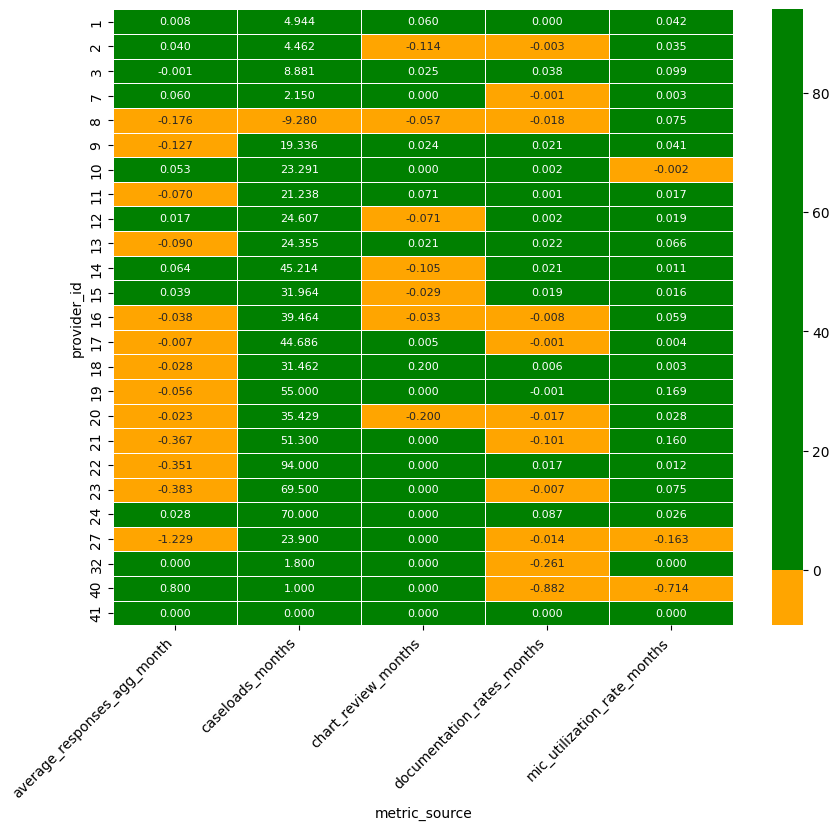

In [83]:
fig, ax = plt.subplots(figsize=(10, 8)) 

sns.heatmap(
    final_result_df_pivot, 
        annot=True,
        fmt=".3f",
        cmap=['orange', 'green'],
        center=0,
        linewidths=0.5,
        annot_kws={"fontsize": 8}
)

plt.xticks(rotation=45, ha='right')

ax_top.set_xticks(ax.get_xticks())
ax_top.set_xticklabels(ax.get_xticklabels())


In [5]:
df_metric_score_metric_target_miss_streak

,provider_id,month_year,metric_source,metric_score,metric_score_imputed,is_imputed,metric_target,has_met_target,num_month_streak_metric_missed_target
0,1,2023-09-01,average_responses_agg_month,NaN,0.0,True,4.0,0.0,1
1,1,2023-10-01,average_responses_agg_month,NaN,0.0,True,4.0,0.0,2
2,1,2023-11-01,average_responses_agg_month,NaN,0.0,True,4.0,0.0,3
3,1,2023-12-01,average_responses_agg_month,NaN,0.0,True,4.0,0.0,4
4,1,2024-01-01,average_responses_agg_month,4.7,4.7,False,4.0,1.0,0
...,...,...,...,...,...,...,...,...,...
920,41,2024-08-01,average_responses_agg_month,NaN,0.0,True,4.0,0.0,1
921,41,2024-08-01,caseloads_months,16.0,16.0,False,337.0,0.0,1
922,41,2024-08-01,chart_review_months,NaN,0.0,True,0.8,0.0,1
923,41,2024-08-01,documentation_rates_months,1.0,1.0,False,0.9,1.0,0


In [9]:
null_counts = df_metric_score_metric_target_miss_streak\
    .groupby(['provider_id', 'metric_source'])['metric_score']\
    .apply(lambda x: x.isnull().sum()).reset_index(name='null_count')

null_counts_pivot = null_counts.pivot(
    index = 'provider_id',
    columns = 'metric_source',
    values = 'null_count'
)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'average_responses_agg_month'),
  Text(1.5, 0, 'caseloads_months'),
  Text(2.5, 0, 'chart_review_months'),
  Text(3.5, 0, 'documentation_rates_months'),
  Text(4.5, 0, 'mic_utilization_rate_months')])

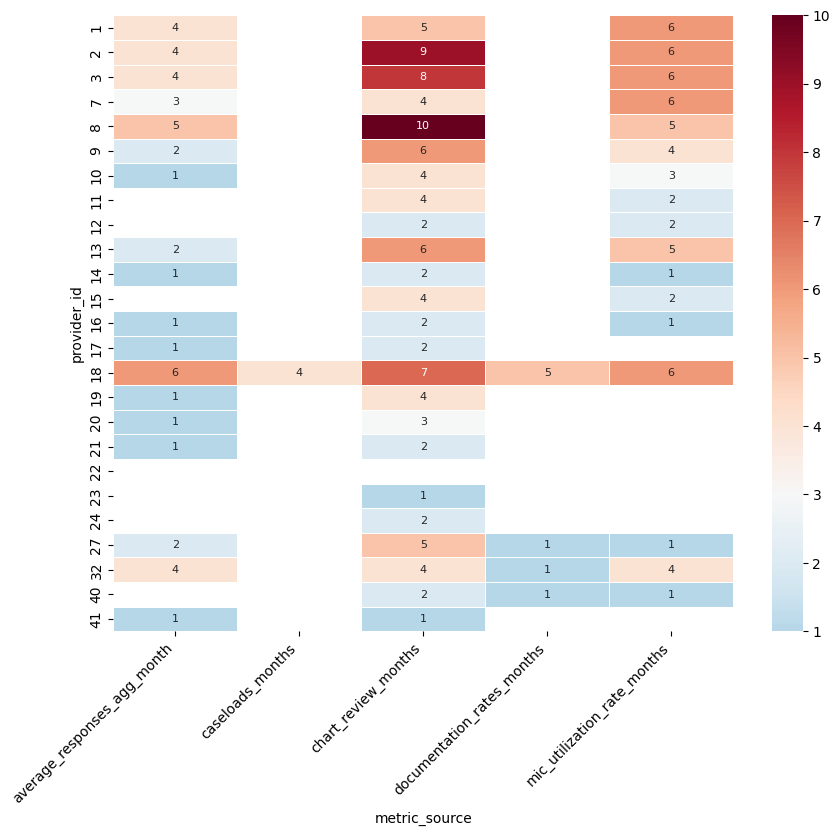

In [21]:
fig, ax = plt.subplots(figsize=(10, 8)) 

mask = null_counts_pivot == 0

sns.heatmap(
    null_counts_pivot, 
        annot=True,
        fmt=".0f",
        cmap="RdBu_r",
        mask=mask,
        center=3,
        linewidths=0.5,
        annot_kws={"fontsize": 8}
)

plt.xticks(rotation=45, ha='right')